### Exercise 5 ###

Implement function tha takes S and $\gamma$ and solve the graphical LASSO

In [6]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [17]:
def solver(S, gamma):

    if not np.allclose(S, S.T):
        raise ValueError("Matrix S must be symmetric.")
    if gamma < 0:
        raise ValueError("Gamma must be non-negative.")

    n = S.shape[0]

    X = cp.Variable((n, n), symmetric=True)

    trace_term = cp.trace(S @ X)
    logdet_term = -cp.log_det(X)

    # L1 penalty on off-diagonal elements
    off_diag_l1 = cp.norm1(cp.vec(X) - cp.vec(cp.diag(cp.diag(X))))

    # Full objective
    objective = cp.Minimize(trace_term + logdet_term + gamma * off_diag_l1)

    # Constraint: X must be positive definite
    constraints = [X >> 0]

    # Solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve()
        
    print("Optimal X:")
    print(X.value)
    return X.value

### Exercise 6 ###
Given the S matrix compute th epoints on thr trade - off curve

In [10]:
S = np.array([
    [1.00, -0.50,  0.10, -0.90],
    [-0.50, 1.25, -0.05,  1.05],
    [0.10, -0.05,  0.26, -0.09],
    [-0.90, 1.05, -0.09,  5.17]
])

In [32]:
def trade_off(S, gammas, method, epsilon=1e-5):

    x_points = []
    y_points = []
    n_no_zeros = []

    interval_zero = [-epsilon, epsilon]
    for gamma in gammas:

        X = method(S, gamma)

        x_points.append(np.trace(S @ X) - np.log(np.linalg.det(X)))

        off_diag_mask = ~np.eye(X.shape[0], dtype=bool)
        off_diag_l1 = np.sum(np.abs(X[off_diag_mask]))
        
        y_points.append(off_diag_l1)

        n_no_zeros.append(np.sum((X[off_diag_mask] < interval_zero[0]) | (X[off_diag_mask] > interval_zero[1])))



    plt.figure(figsize=(8, 6))
    plt.plot(x_points, y_points, marker='o', label='Trade-off Curve')
    plt.xlabel('Trace - LogDet')
    plt.ylabel('L1 Norm of Off-Diagonal Elements')
    plt.title('Trade-off Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(gammas, n_no_zeros, marker='o', label='Number of Non Zeros')
    plt.xlabel('Gamma')
    plt.ylabel('Number of Non Zeros in X')
    plt.title('Number of Non Zeros vs Gamma')
    plt.legend()
    plt.grid(True)
    plt.show()




Optimal X:
[[ 1.35863123e+00  3.96322950e-01 -3.57286131e-01  1.48624394e-01]
 [ 3.96322950e-01  1.07922066e+00 -1.16859424e-09 -1.48870982e-01]
 [-3.57286131e-01 -1.16859424e-09  3.96984799e+00  1.15885992e-09]
 [ 1.48624394e-01 -1.48870982e-01  1.15885992e-09  2.48947819e-01]]
Optimal X:
[[ 1.34514439e+00  3.87395428e-01 -3.29249378e-01  1.47709401e-01]
 [ 3.87395428e-01  1.07223152e+00 -9.75338925e-09 -1.48116948e-01]
 [-3.29249378e-01 -9.75338925e-09  3.95166650e+00 -2.62909678e-09]
 [ 1.47709401e-01 -1.48116948e-01 -2.62909678e-09  2.48255918e-01]]
Optimal X:
[[ 1.32400447e+00  3.72860572e-01 -2.83269089e-01  1.46190179e-01]
 [ 3.72860572e-01  1.06093826e+00 -2.84653441e-09 -1.46859770e-01]
 [-2.83269089e-01 -2.84653441e-09  3.92477414e+00  6.36815409e-09]
 [ 1.46190179e-01 -1.46859770e-01  6.36815409e-09  2.47116953e-01]]
Optimal X:
[[ 1.29235698e+00  3.49549900e-01 -2.08394017e-01  1.43675321e-01]
 [ 3.49549900e-01  1.04306872e+00 -3.77876556e-09 -1.44765470e-01]
 [-2.08394017e-

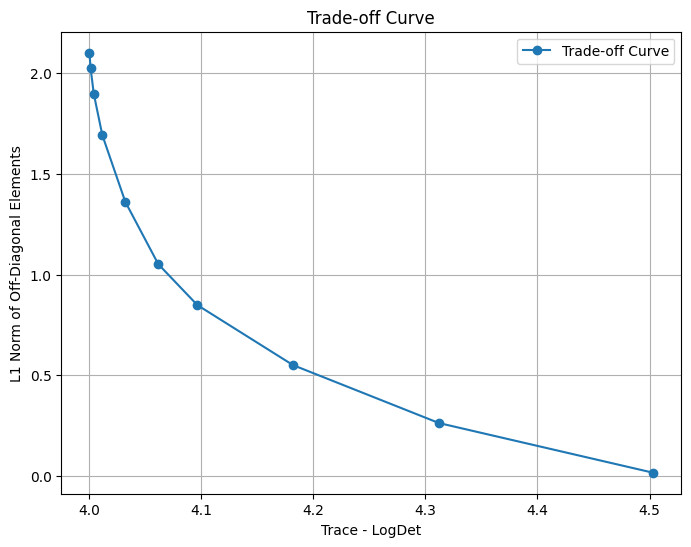

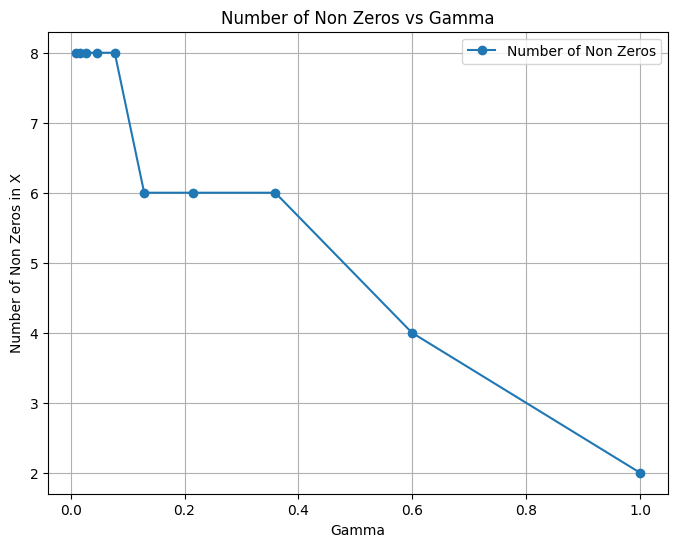

In [34]:
gammas = np.logspace(-2, 0, 10)

trade_off(S, gammas, solver)

### Exercise 7 ###

Implement proximal gradient method for solving graphical LASSO problem

In [1]:
def grad_x(X, S):

    X_inv = np.linalg.inv(X)
    return S - X_inv

In [2]:
def arg_prox(X, t, grad_x, S):

    return X - t * grad_x(X, S)

In [3]:
def h_func_cp(X, gamma):
    offdiag_mask = ~np.eye(X.shape[0], dtype=bool)
    return gamma * cp.norm1(cp.multiply(offdiag_mask, X))

In [4]:
def h_func(X, gamma):
    offdiag_mask = ~np.eye(X.shape[0], dtype=bool)
    return gamma * np.sum(np.abs(np.multiply(offdiag_mask, X)))

In [11]:
# Test h_func

X = np.array([[1., 0.2, 0.1, 0.3],
              [0.2, 1., 0.4, 0.5],
              [0.1, 0.4, 1., 0.6],
              [0.3, 0.5, 0.6, 1.]])
gamma = 0.05
h_value = h_func(X, gamma)
print("Value of h_func:")
print(h_value)

Value of h_func:
0.21000000000000002


In [12]:
def prox_h(X, h_func_cp, t, grad_x, arg_prox, S, gamma):
    """
    Compute prox_{h}(x) = argmin_y h(y) + 0.5 * ||y - x||_2^2

    Parameters:
    - x (np.ndarray): The point at which to evaluate the proximal operator
    - h_func_cp (callable): A function that accepts a cvxpy Variable y and returns h(y)

    Returns:
    - np.ndarray: Result of the proximal operator
    """
    x = arg_prox(X, t, grad_x, S)

    y = cp.Variable(x.shape)
    objective = h_func_cp(y, gamma) + 0.5 * cp.sum_squares(y - x)
    problem = cp.Problem(cp.Minimize(objective))
    problem.solve()
    return y.value


In [13]:
# Define a sample X
X = np.eye(4)  # Identity matrix as an example

# Define a step size t
t = 0.1
gamma = 0.0005

# Test the prox_h function
result = prox_h(X, h_func_cp, t, grad_x, arg_prox, S, gamma)
print("Result of prox_h:")
print(result)

Result of prox_h:
[[ 1.      0.0495 -0.0095  0.0895]
 [ 0.0495  0.975   0.0045 -0.1045]
 [-0.0095  0.0045  1.074   0.0085]
 [ 0.0895 -0.1045  0.0085  0.583 ]]


In [14]:
import numpy as np

def compute_U(X, S, gamma):
    """
    Compute U where:
    U_ij = max(-gamma, min(gamma, [X_inv - S]_ij)) for i ≠ j
           0 for i == j
    
    Parameters:
    - X (np.ndarray): Square positive definite matrix
    - S (np.ndarray): Symmetric matrix of same shape as X
    - gamma (float): Threshold parameter
    
    Returns:
    - np.ndarray: Matrix U
    """
    X_inv = np.linalg.inv(X)
    diff = X_inv - S

    # Apply soft thresholding only to off-diagonal elements
    U = np.zeros_like(diff)
    for i in range(diff.shape[0]):
        for j in range(diff.shape[1]):
            if i != j:
                U[i, j] = np.clip(diff[i, j], -gamma, gamma)
            else:
                U[i, j] = 0  # optional, since we initialized with zeros

    return U


In [15]:
def g_func(X, S):
    return np.trace(S @ X) + np.log(np.linalg.det(X))

In [16]:
def compute_stopping_criterion(X, S, g_func, h_func, gamma, compute_U):

    n = X.shape[0]

    delta = g_func(X, S) + h_func(X, gamma) - np.log(np.linalg.det(S + compute_U(X, S, gamma))) - n
    
    return delta

In [17]:
# Test compute_stopping_criterion

delta = compute_stopping_criterion(X, S, g_func, h_func, gamma, compute_U)
print("Stopping Criterion (delta):", delta)

Stopping Criterion (delta): 3.678891663579476


In [18]:
def proximal_gradient_descend(X, h_func_cp, h_func, t, grad_x, arg_prox, S, gamma, g_func, compute_U, epsilon=1e-2): # TODO : i'm not fucking sure this work, can you guys check please 

    while True:
        X_new = prox_h(X, h_func_cp, t, grad_x, arg_prox, S, gamma)
        delta = compute_stopping_criterion(X_new, S, g_func, h_func, gamma, compute_U)

        X = X_new

        if delta <= epsilon:
            break 
    
    return X


In [19]:
# Test proximal_gradient_descend
X_initial = np.eye(S.shape[0])  # Start with an identity matrix
epsilon = 1e-1  # Convergence threshold

result_pg = proximal_gradient_descend(
    X_initial, h_func_cp, h_func, t, grad_x, arg_prox, S, gamma, g_func, compute_U, epsilon
)

print("Result of Proximal Gradient Descent:")
print(result_pg)

Result of Proximal Gradient Descent:
[[ 1.00186921  0.0920112  -0.01793583  0.16209319]
 [ 0.0920112   0.95505627  0.0083404  -0.18908665]
 [-0.01793583  0.0083404   1.14113502  0.01536052]
 [ 0.16209319 -0.18908665  0.01536052  0.24371533]]


In [21]:
def backtracking_line_search(phi, phi_derivative_at_0, t_init, alpha1=0.1, beta=0.7):
    """
    Perform backtracking line search to find step size t.

    Parameters:
        phi (function): A continuously differentiable function φ: R → R.
        phi_derivative_at_0 (float): The derivative φ'(0).
        t_init (float): Initial step size (t >= 0).
        alpha1 (float): Parameter in (0, 0.5], default 0.1.
        beta (float): Parameter in (0, 1), default 0.7.

    Returns:
        float: Step size t such that φ(t) ≤ φ(0) + α1 * t * φ'(0)
    """
    t = t_init
    phi_0 = phi(0)

    while phi(t) > phi_0 + alpha1 * t * phi_derivative_at_0:
        t *= beta

    return t

In [114]:
def proximal_gradient_descent_backtracking(
    X, h_func_cp, h_func, t_init, grad_x, arg_prox, S, gamma,
    g_func, compute_U, epsilon=1e-2, alpha=0.1, beta=0.5, max_iter=100
):
    """
    Proximal gradient descent with backtracking line search for Graphical Lasso.
    """

    def objective(X_val, S, gamma):
        return g_func(X_val, S) + h_func(X_val, gamma)

    while True:
        t = t_init
        for _ in range(max_iter):
            X_new = prox_h(X, h_func_cp, t, grad_x(X, S), arg_prox, S, gamma)
            # Armijo condition
            lhs = objective(X_new, S, gamma)

            rhs = objective(X, S, gamma) + alpha * np.sum(grad_x(X, S) * (X_new - X))  # <∇g(X), X_new - X>
            if lhs <= rhs:
                break
            t *= beta  # backtrack if Armijo not satisfied

        delta = compute_stopping_criterion(X_new, S, g_func, h_func, gamma, compute_U)
        X = X_new

        if delta <= epsilon:
            break

    return X


### Exercise 8 ###

Find the precision matrix of given data while varying the $\gamma$

In [32]:
from sklearn.covariance import GraphicalLasso
import numpy as np

matrix = np.loadtxt('data/sp500.txt')

gammas = np.logspace(-2, -1, 10)


Estimated precision matrix (inverse covariance):
 [[-inf  -0.   0. ...  -0.  -0.  -0.]
 [ -0. -inf   0. ...  -0.  -0.  -0.]
 [  0.   0. -inf ...   0.   0.   0.]
 ...
 [ -0.  -0.   0. ... -inf  -0.  -0.]
 [ -0.  -0.   0. ...  -0. -inf  -0.]
 [ -0.  -0.   0. ...  -0.  -0. -inf]]


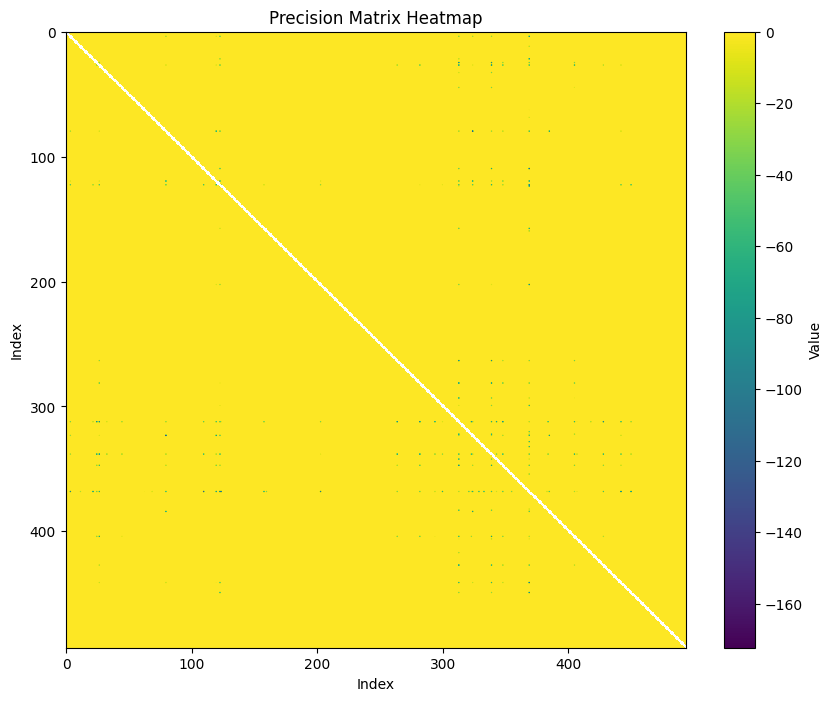

In [ ]:


# Fit Graphical LASSO
model = GraphicalLasso(alpha=0.001)  # alpha = regularization parameter (similar to gamma)
model.fit(matrix)

# Access results
precision_matrix = model.precision_  # Estimated inverse covariance (Θ)

np.fill_diagonal(precision_matrix, -np.inf)
covariance_matrix = model.covariance_

print("Estimated precision matrix (inverse covariance):\n", precision_matrix)

plt.figure(figsize=(10, 8))
plt.imshow(precision_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label='Value')
plt.title('Precision Matrix Heatmap')
plt.xlabel('Index')
plt.ylabel('Index')
plt.show()

In [37]:
def trade_off_non_zeros_prox(S, gammas, epsilon=1e-5):

    x_points = []
    y_points = []
    n_no_zeros = []

    interval_zero = [-epsilon, epsilon]

    for gamma in gammas:

        model = GraphicalLasso(alpha=gamma) 
        model.fit(matrix)
        X = model.precision_ 

        x_points.append(np.trace(S @ X) - np.log(np.linalg.det(X)))

        off_diag_mask = ~np.eye(X.shape[0], dtype=bool)
        off_diag_l1 = np.sum(np.abs(X[off_diag_mask]))
        
        y_points.append(off_diag_l1)

        n_no_zeros.append(np.sum((X[off_diag_mask] < interval_zero[0]) | (X[off_diag_mask] > interval_zero[1])))



    plt.figure(figsize=(8, 6))
    plt.plot(x_points, y_points, marker='o', label='Trade-off Curve')
    plt.xlabel('Trace - LogDet')
    plt.ylabel('L1 Norm of Off-Diagonal Elements')
    plt.title('Trade-off Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(gammas, n_no_zeros, marker='o', label='Number of Non Zeros')
    plt.xlabel('Gamma')
    plt.ylabel('Number of Non Zeros in X')
    plt.title('Number of Non Zeros vs Gamma')
    plt.legend()
    plt.grid(True)
    plt.show()



/opt/anaconda3/envs/env_ml_sp/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/anaconda3/envs/env_ml_sp/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/anaconda3/envs/env_ml_sp/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/anaconda3/envs/env_ml_sp/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/anaconda3/envs/env_ml_sp/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/anaconda3/envs/env_ml_sp/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarni

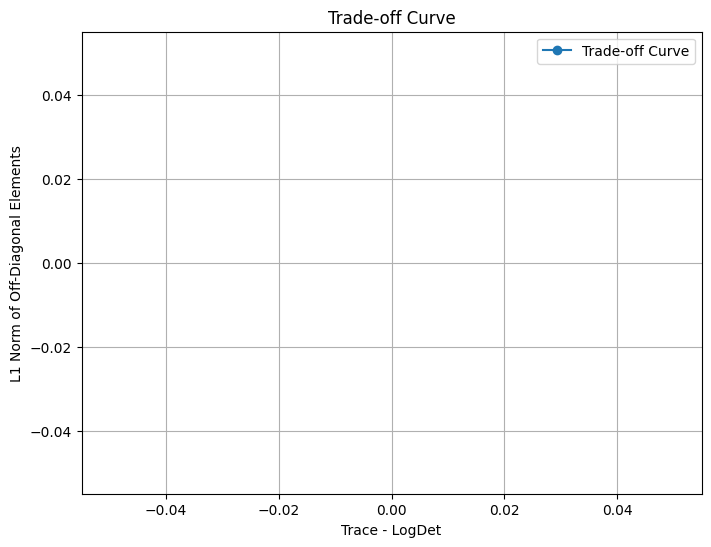

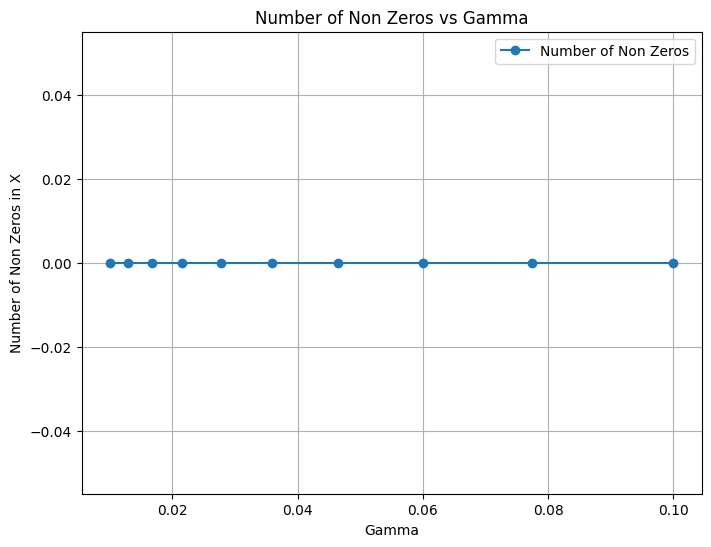

In [38]:
trade_off_non_zeros_prox(matrix, gammas, epsilon=1e-10)